In [ ]:
import numpy as np
import pandas as pd
import math
import os
import requests
import csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences

from imblearn.under_sampling import RandomUnderSampler

from rdkit import Chem
from rdkit.Chem import RDKFingerprint
from rdkit.Chem import rdMolDescriptors

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_score, recall_score

## EXTRACT DATA
CSV file to be present in local machine.<br>
FIle name is data.csv

In [ ]:
# Downloading the data from the GitHub repository
if os.path.exists("data.csv"):
  print("Data already downloaded, skipping download....")
else:
  url = 'https://github.com/sriskid/hts_active_learning/raw/main/data.csv'
  res = requests.get(url, allow_redirects=True)
  
  with open('data.csv','wb') as f:
    print("Downloading data....")
    f.write(res.content)

In [ ]:
data = []
with open('data.csv', 'r') as csvfile: 
    reader = csv.reader(csvfile, skipinitialspace=True)
    data.append(tuple(next(reader))) # header
    for ID, SMILE, B, RES, is_active in reader:
        data.append((ID, SMILE, B, RES, is_active)) #append data as tuple

# remove header
data = data[1:]
maxlen = len(data)
print('Number of entries processed: ', maxlen)

Number of entries processed:  29537


In [ ]:
# Get only the SMILES data
SMILES = []
for i in data:
    SMILES.append(i[1])

## ONE-HOT ENCODING OF SMILES
This will help in vectrorizing smiles data.<br>
This section will use the tokenizer function that is provided in tensorflow, and we will use keras as the front-end to access the function.<br>
Credit: https://www.kaggle.com/code/art3mis/220221-getting-started-with-smiles <br>
Inspiration: https://towardsdatascience.com/basic-molecular-representation-for-machine-learning-b6be52e9ff76

In [ ]:
# Create a tokenizer for vectorization. 
tokenizer = Tokenizer(char_level=True, lower=False) 

# Create the vocabulary index based on the word frequency in the text data.
tokenizer.fit_on_texts(SMILES)    

# Encoding text_to_sequences
sequences = tokenizer.texts_to_sequences(SMILES)

# Pads sequences to the same length. 
pad_data = pad_sequences(sequences, maxlen = len(max(sequences, key=len)))\

Encoded string: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  

In [ ]:
def decodeOH2SMILES(array, tokenizer):
    # Converts one-hot encoded sequences back to SMILES strings.
    output = tokenizer.sequences_to_texts(array)

    #Modify this if you change the start or end token.
    disallowed_characters = 'E! ' # == unspecified charge* drop it.

    for character in disallowed_characters:
        output = [i.replace(character,'') for i in output]
    return output

In [ ]:
decoded_smiles = decodeOH2SMILES(pad_data[0:2],tokenizer)

['c1(c2c([nH]c1)ccc(c2)OCc1ccccc1)CN(C)C', 'c12[nH]c3c(c1CCN=C2C)ccc(c3)O.Cl.O']


## MOLECULAR FINGERPRINT ENCODING OF SMILES
This will help in converting smiles data so that it can be used for applying ML techniques. This is more often used (from surveying)<br>
Credit: https://towardsdatascience.com/basic-molecular-representation-for-machine-learning-b6be52e9ff76

In [ ]:
# We will be using RDK fingerprint to vectorize all our SMILES structures
fingerprints = []
for i in range(len(SMILES)):
    mol = Chem.MolFromSmiles(SMILES[i])
    fingerprint_rdk = np.array(RDKFingerprint(mol))
    fingerprints.append(fingerprint_rdk)
fingerprints = np.array(fingerprints)
fingerprints

[07:18:46] WARNING: not removing hydrogen atom without neighbors


array([[1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0]])

## VISUALIZATION OF DATA
Data is obtained from the following paper - https://doi.org/10.1371/journal.pcbi.1010613 <br>
In this paper (and a previous paper of theirs), they conducted a series of HTS to obtain the Average B-score and residual values for a series of small molecules to see their potency against Burkholderia cenocepacia.<br>
Quoting the paper,<br>

"The dataset used in the ML approach consisted of 29,537 compounds with residual growth (RG) values and average B-scores. The RG measures the ratio of bacterial growth in the presence and absence of the compounds. The B-score measures relative potency that adjusts the RG for any screening artifacts resulting from well position (row and column) in the assay plate during the HTS. The B-score is inversely proportional to compound potency, where negative B-scores indicate greater growth inhibitory activity of the compounds. To binarize the compounds, the previously established average B-score threshold of -17.5 was chosen [https://doi.org/10.1371/journal.pone.0128587]. Overall, 256 small molecules were classified as growth inhibitory."

Staying true to the essence of the paper, we will be setting a threshold of -17.5 for B-score in our data as well, i.e. below this threshold, the compound is labeled active, and otherwise inactive.

In [ ]:
# Checking data for number of active compounds
# idx - ID, SMILE, B, RES, is_active
count = 0
for i in range(len(data)):
    if float(data[i][2]) <= -17.5:
        if float(data[i][4]) == 1:
            count += 1
print("Number of active compounds =",count)
# This follows what is mentioned in the paper.

Number of active compounds = 256


In [ ]:
# Get the B-score values
Bscores = []
active = []
is_active = []
for i in range(len(data)):
    Bscores.append(float(data[i][2]))

    is_active.append(float(data[i][4]))

    if float(data[i][4]) == 0:
        active.append("Inactive")
    else:
         active.append("Active")
            
compound_idx = np.arange(len(Bscores))
is_active = np.array(is_active)

[Text(0.5, 0, 'Compound Index'), Text(0, 0.5, 'B-Score')]

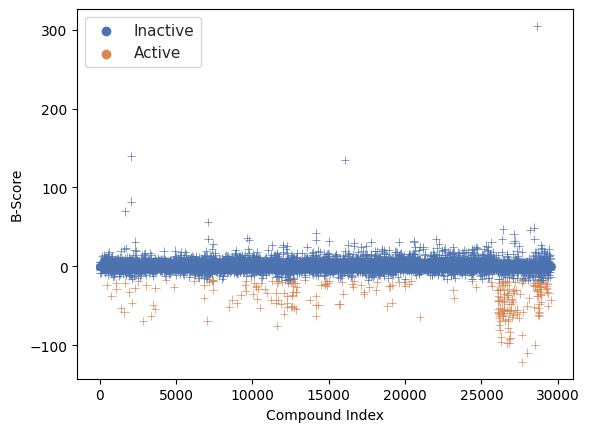

In [ ]:
# Visualizing data
# Plot B-scores

fig, ax = plt.subplots()
# plt.scatter(compound_idx[0:100], Bscores[0:100], c ="blue")
sns.set(style='whitegrid')
sns.scatterplot(x=compound_idx,
                    y=Bscores,
                    hue=active, marker='+')

# ax.set_ylim(-500, 100)
ax.set(xlabel='Compound Index', ylabel='B-Score')

## SPLITTING OF DATA
This is an important section because our data is heavily unbalanced. Therefore, we do random undersampling of the major class.


Expected Model Change

## IMPLEMENTING LOGISTIC REGRESSION ON MOLECULAR FINGERPRINTS
Logistic regression will be our base learner for this project. Below is the passive learning implementation for the same.

In [ ]:
class LogR():
    '''
    logistic regression class
    '''
    def __init__(self, x, y):
        self.trainX = x
        self.trainY = y.reshape(len(y),)
        self.model = LogisticRegression(random_state=0, max_iter=500)

    def fit(self):
        self.model.fit(self.trainX, self.trainY)
        
    def predict(self, x):
        return self.model.predict(x)

    def predict_prob(self, x):
        return self.model.predict_proba(x)

    # def predict_logprob(self, x):
    #     return self.model.predict_log_proba(x)

    def generate_acc(self, true, pred):
        return accuracy_score(true, pred)

In [ ]:
# Functions for Expected Model Change
def calc_dEdw(data, label, y_pred):
    '''
    data: df
    returns dEdw (vector w/ len of n_features)
    '''
    assert len(data)==len(label)
    
    return (1/len(data)) * np.dot(data.T, (y_pred[:,1] - label)) # y_pred[:,1] == P(Y=1|X)

def calc_dEdb(label, y_pred):
    '''
    returns dEdb (vector with len of n_samples)
    '''
    return (1/len(label)) * np.sum((y_pred[:,1] - label))
    
def calc_emc(model, dEdw, dEdb, new_x):
    '''
    new_x: sampled that is being tested whether to be sampled or not
    '''
    dEdw_sq = np.dot(dEdw,dEdw)
    dEdb_sq = dEdb**2

    norm = math.sqrt(sum([dEdw_sq, dEdb_sq]))
    
    label_pred = model.predict_prob(new_x)

    y_prob_0 = label_pred[0][0] 
    y_prob_1 = label_pred[0][1]
    
    return sum([y_prob_0*norm, y_prob_1*norm])
    

def expected_model_change(data, data_pool):
    '''
    data: DF. Queried data in here.
    data_pool: DF. Labeled data pool from which we select new sample.
    
    Search through data_pool to look for 
    a sample that changes the gradient the most.
    
    Returns selected sample. 
    '''
    max_v = float('-inf')
    max_idx = -1
    model_saved = None
    
    #loop through data_pool & search sample that brings biggest change in gradient
    for i,r in data_pool.iterrows():
        row_df = pd.DataFrame([r], index=[i], columns=r.index)
        tmp_data_for_emc = pd.concat([data, row_df], axis=0) # non-destructive. data should remain the same.

        x = tmp_data_for_emc.loc[:, tmp_data_for_emc.columns!='y'].to_numpy() #2d
        y = tmp_data_for_emc['y'].to_numpy() #1d
        
        #fit to logistic regression model including updated data
        model = LogR(x, y)
        model.fit()
        
        # calc probabilities of y 
        y_prob = model.predict_prob(x)
    
        dEdw = calc_dEdw(x, y, y_prob)
        dEdb = calc_dEdb(y, y_prob)
        
        new_x = row_df.loc[:, row_df.columns!='y'].to_numpy()
        
        emc = calc_emc(model, dEdw, dEdb, new_x)

        if emc > max_v:
            max_v=emc
            max_idx=i
            model_saved = model

    # update remaining data with drop() & return one new sample
    sampled_df = data_pool.loc[[max_idx]]
    data_pool.drop(index=[max_idx], inplace=True)

    return sampled_df, model_saved

def calc_acc_prec_rec(model, data_pool):
    testX = data_pool.loc[:, data_pool.columns!='y'].to_numpy()
    testY = data_pool['y'].to_numpy()

    y_pred = model.predict(testX)

    accuracy = model.generate_acc(testY, y_pred)
    precision = precision_score(testY, y_pred)
    recall = recall_score(testY, y_pred)

    return accuracy, precision, recall

def run_l_simulations_expected_model_change(fingerprints, is_active, m = 475):
    '''
    fingerprints: original data (np array)
    is_active: label for original data (int)
    
    returns l by m np.array
    (1) l number of simulations
    (2) m rounds of updates 
    '''
    assert len(fingerprints) == len(is_active)
    
    # store accuracy here    
    l_sim_accuracy_ls = np.zeros((10, m+1))
    l_sim_precision_ls = np.zeros((10, m+1))
    l_sim_recall_ls = np.zeros((10, m+1))
    l_sim_f1_ls = np.zeros((10, m+1))
    
    rus = RandomUnderSampler(random_state=10)
    X_resampled, y_resampled = rus.fit_resample(fingerprints, active)
    
    # attach label
    original_data = pd.DataFrame(X_resampled)
    original_data['y'] = y_resampled
    original_data['y'] = (original_data['y']=='Active').astype(int)

    for i in range(5,7): # l simulations
        print('simulation: ',i)
        data_pool = original_data.copy(deep=True)
        np.random.seed(i+10)
        
        # for m updates
        for j in range(m+1): #+1 for including initial random sampling
            if j==0:
                x = original_data.loc[:, original_data.columns!='y'].to_numpy()
                y = original_data['y'].to_numpy()

                rand_idx = np.random.permutation(len(x))

                # initial random sampling is 5% of the train data
                init_size = round(len(x) * 0.05)

                data_x = x[rand_idx[0:init_size]]
                data_pool_x = x[rand_idx[init_size:len(x)]]
                
                data_y = y[rand_idx[0:init_size]]
                data_pool_y = y[rand_idx[init_size:len(x)]]
                ################################################# ^randomly shuffle data
                data = pd.DataFrame(data_x)
                data['y'] = data_y
                
                data_pool = pd.DataFrame(data_pool_x)
                data_pool['y'] = data_pool_y

                #fit to logistic regression model including updated data
                model = LogR(data_x, data_y)
                model.fit()
                
                accuracy, precision, recall = calc_acc_prec_rec(model, data_pool)
                
                #append curr update round, and curr accuracy as tuple  
                l_sim_accuracy_ls[i,j] = accuracy
                l_sim_precision_ls[i,j] = precision
                l_sim_recall_ls[i,j] = recall
                l_sim_f1_ls[i,j] = f1
                
            else:
                # sample one using expected model change query.
                # returns instance sampled usding EMC, fitted model trained with the sampled data.
                emc_sample, model = expected_model_change(data, data_pool)
                data = pd.concat([data, emc_sample], axis=0)
                
                # test on test dataset
                testX = data_pool.loc[:, data_pool.columns!='y'].to_numpy()
                testY = data_pool['y'].to_numpy()
                
                y_pred = model.predict(testX)
                
                accuracy, precision, recall = calc_acc_prec_rec(model, data_pool)

                #append curr update round, and curr accuracy as tuple  
                l_sim_accuracy_ls[i,j] = accuracy
                l_sim_precision_ls[i,j] = precision
                l_sim_recall_ls[i,j] = recall
                l_sim_f1_ls[i,j] = f1

    return l_sim_accuracy_ls, l_sim_precision_ls, l_sim_recall_ls

In [ ]:
l_sim_accuracy_ls, l_sim_precision_ls, l_sim_recall_ls = run_l_simulations_expected_model_change(fingerprints, active)

simulation:  5
data.shape (26, 2049)
data_pool.shape (486, 2049)
accuracy 0.5781893004115226
precision 0.5664335664335665
recall 0.6666666666666666

data.shape (27, 2049)
data_pool.shape (485, 2049)
accuracy 0.5917525773195876
precision 0.5650887573964497
recall 0.7892561983471075

data.shape (28, 2049)
data_pool.shape (484, 2049)
accuracy 0.5909090909090909
precision 0.569620253164557
recall 0.743801652892562

data.shape (29, 2049)
data_pool.shape (483, 2049)
accuracy 0.6149068322981367
precision 0.579250720461095
recall 0.8340248962655602

data.shape (30, 2049)
data_pool.shape (482, 2049)
accuracy 0.58298755186722
precision 0.5506493506493506
recall 0.8833333333333333

data.shape (31, 2049)
data_pool.shape (481, 2049)
accuracy 0.5841995841995842
precision 0.554945054945055
recall 0.8416666666666667

data.shape (32, 2049)
data_pool.shape (480, 2049)
accuracy 0.58125
precision 0.5582089552238806
recall 0.7791666666666667

data.shape (33, 2049)
data_pool.shape (479, 2049)
accuracy 0.597

In [ ]:
def calc_mean_sd_of_each_update(data_ls):
    '''
    calc mean and sd of each update round
    return list of mean and list of sd
    '''
    mean=[]
    sd=[]
    for update_idx in range(len(data_ls[0])):
        mean.append(data_ls[:,update_idx].mean())
        sd.append(data_ls[:,update_idx].std())
    return mean, sd

In [ ]:
# Plot accuracy and f1 score
acc_mean, acc_sd = calc_mean_sd_of_each_update(acc_copy)
f1_mean, f1_sd = calc_mean_sd_of_each_update(f1)

In [ ]:
x = np.arange(476)

# Create plot
sns.set_style("whitegrid")

step_size = 50
x_subset = x[::step_size]

# accuracy
y1_subset = acc_mean[::step_size]
acc_std_subset = acc_sd[::step_size]
# f1 score
y2_subset = f1_mean[::step_size]
f1_std_subset = f1_sd[::step_size]

# Create line plot with error bars
sns.lineplot(x=x, y=acc_mean, errorbar='ci', color="black", err_style='bars')
sns.lineplot(x=x, y=f1_mean, errorbar='ci', color="red", err_style='bars')

# Overlay error bars for the subset of data
plt.errorbar(x=x_subset, y=y1_subset, yerr=acc_std_subset, fmt='none', color='black', capsize=5, label='accuracy')# plt.plot(xaxis, avg_acc)
plt.errorbar(x=x_subset, y=y2_subset, yerr=f1_std_subset, fmt='none', color='red', capsize=5, label='f1')# plt.plot(xaxis, avg_acc)

plt.ylabel("Performance")
plt.xlabel("No. of samples in training set")
# plt.savefig(".png")
plt.show()